In [ ]:
!pip install -U sentence-transformers
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 29.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure,show,output_notebook
import pyLDAvis
import pyLDAvis.gensim_models
from sentence_transformers import SentenceTransformer
import warnings
import pprint
import tensorflow as tf

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/My Drive/metadata.csv',
                  usecols=['cord_uid','source_x','title','license','publish_time',
                           'abstract','authors','journal','url'])
data.head()

Mounted at /content/gdrive


,cord_uid,source_x,title,license,abstract,publish_time,authors,journal,url
0,ug7v899j,PMC,Clinical features of culture-proven Mycoplasma...,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...
1,02tnwd4m,PMC,Nitric oxide: a pro-inflammatory mediator in l...,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
2,ejv2xln0,PMC,Surfactant protein-D and pulmonary host defense,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
3,2b73a28n,PMC,Role of endothelin-1 in lung disease,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
4,9785vg6d,PMC,Gene expression in epithelial cells in respons...,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...


In [ ]:
data = data[data.publish_time=='2021']
print(f'There are {len(data)} articles published in 2021')

There are 233709 articles published in 2021


In [ ]:
len1 = len(data)
data.dropna(axis=0,how='any',subset=['abstract'],inplace=True)
print(f'Dropped {len1-len(data)} articles with missing abstract')

Dropped 50192 articles with missing abstract


In [ ]:
len1 = len(data)
data.drop_duplicates(subset=['abstract'],keep='first',inplace=True)
print(f'Dropped {len1-len(data)} articles with duplicate abstract')

Dropped 26181 articles with duplicate abstract


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

data['abstract'] = data['abstract'].apply(lambda x: x.strip().lower())
stopwords = set(stopwords)
data['abstract_tokens'] = data['abstract'].apply(lambda x: word_tokenize(x))

## Remove non-English words
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w.isalpha()])

## Remove Stopwords
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w not in stopwords])

## Remove words with single characters
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if len(w)>1])
#data['abstract_cleaned'] = data['abstract_tokens'].apply(lambda x: ' '.join(x))
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,cord_uid,source_x,title,license,abstract,publish_time,authors,journal,url,abstract_tokens
15233,ilsrad9a,PMC,Tomographic findings in bronchial atresia,cc-by,objective: to evaluate computed tomography (ct...,2021,"Puglia, Elazir Barbosa Mota Di; Rodrigues, Ros...",Radiol Bras,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"[objective, evaluate, computed, tomography, ct..."
16337,30svjjwj,PMC,In Vitro Antileishmanial Effects of Saffron Co...,cc-by-nc,background: due to numerous side effects of co...,2021,"RANJBAR, Reza; SHAYANFAR, Peyman; MANIATI, Mah...",Iran J Parasitol,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"[background, due, numerous, side, effects, com..."
17333,nn5v2q3e,PMC,Is This Science? Students’ Experiences of Fail...,cc-by-nc-sa,course-based undergraduate research experience...,2021,"Goodwin, Emma C.; Anokhin, Vladimir; Gray, Mac...",CBE Life Sci Educ,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...,"[undergraduate, research, experiences, cures, ..."
20404,xzrxh98e,PMC,Is Telemedicine our cup of tea? A nationwide c...,cc-by,objectives: to evaluate the experience and per...,2021,"Alam, Laima; Alam, Mafaza; Malik, Amina Mannan...",Pak J Med Sci,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...,"[objectives, evaluate, experience, perceptions..."
21056,553o9n0m,PMC,The Drug Resistance of Plasmodium falciparum a...,cc-by-nc,background: one of the main obstacles to malar...,2021,"Heidari, Aliehsan; Keshavarz, Hossein",Iran J Parasitol,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...,"[background, one, main, obstacles, malaria, co..."


In [ ]:
data.reset_index(drop=True,inplace=True)

In [ ]:
inverted_idx = {}
for idx,sentence in enumerate(list(data['abstract_tokens'])):
    for token in set(sentence):
        if token not in inverted_idx:
            inverted_idx[token] = [idx]
        else:
            inverted_idx[token].append(idx)

print(f'There are {len(inverted_idx)} unique words in inverted index')

There are 221529 unique words in inverted index


In [ ]:
keywords_risk = ['risk','risky','risks','risked','risking']
risk_idx = []
for word in keywords_risk:
    try:
        risk_idx += inverted_idx[word]
    except:
        pass
risk_idx = list(set(risk_idx))
print(f'Found {len(risk_idx)} articles related to risk')

Found 28948 articles related to risk


In [ ]:
risk_article = data.iloc[risk_idx,:]
risk_article.head()

,cord_uid,source_x,title,license,abstract,publish_time,authors,journal,url,abstract_tokens
131072,dhe2gu8o,WHO,Addressing cancer survivors’ cardiovascular he...,unk,background: the purpose of this paper is to de...,2021,"Foraker, R. E.; Davidson, E. C.; Dressler, E. ...",Contemporary Clinical Trials Communications,NaN,"[background, purpose, paper, describe, automat..."
3,xzrxh98e,PMC,Is Telemedicine our cup of tea? A nationwide c...,cc-by,objectives: to evaluate the experience and per...,2021,"Alam, Laima; Alam, Mafaza; Malik, Amina Mannan...",Pak J Med Sci,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...,"[objectives, evaluate, experience, perceptions..."
131081,47huo0eo,WHO,COVID-19 and Fast Foods Consumption: a Review,unk,while all groups are affected by the covid-19 ...,2021,"Bohlouli, J.; Moravejolahkami, A. R.; Ganjali ...",International Journal of Food Properties,NaN,"[groups, affected, pandemic, aged, people, wel..."
131083,phjhuno3,WHO,Whole blood chromium concentration is very rar...,unk,due to the risk of adverse reactions to metal ...,2021,"Lainiala, Olli; Karsikas, Mari; Reito, Aleksi;...",Sci Rep,NaN,"[due, risk, adverse, reactions, metal, debris,..."
131095,4ffygdm5,WHO,Adaptive social contact rates induce complex d...,unk,epidemics may pose a significant dilemma for g...,2021,"Arthur, Ronan F; Jones, James H; Bonds, Matthe...",PLoS Comput Biol,NaN,"[epidemics, may, pose, significant, dilemma, g..."


In [ ]:
def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        ##'-PRON-' is used as the lemma for all pronouns such as their, you, me, and I
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else ''
                          for token in doc if token.pos_ in allowed_postags])
    return texts_out

Text(0.5, 1.0, 'Word Cloud: Articles Related to Risk Factor')

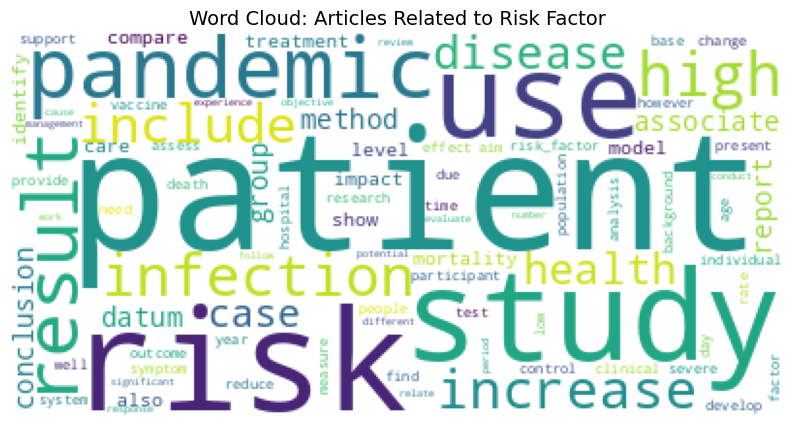

In [ ]:
risk_article['Lemma_Tokens'] = lemmatization(list(risk_article['abstract_tokens']))
## convert tokens that frequently occur together as bigram and trigram
bigram = Phrases(list(risk_article['Lemma_Tokens']), min_count=3)
risk_article['Phrase_Lemma_Tokens'] = risk_article['Lemma_Tokens'].apply(lambda x: bigram[x])
#trigram = Phrases(list(risk_article['Phrase_Lemma_Tokens']), min_count=5)
#risk_article['Phrase_Lemma_Tokens'] = risk_article['Phrase_Lemma_Tokens'].apply(lambda x: trigram[x])

risk_abstract_tokens = []
for tokens in list(risk_article['Phrase_Lemma_Tokens']):
    risk_abstract_tokens += tokens
risk_wordcnt_dict = collections.Counter(risk_abstract_tokens)

wcloud = wordcloud.WordCloud(background_color='white')
wcloud.generate_from_frequencies(risk_wordcnt_dict)
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(wcloud)
for pos in ['left','right','top','bottom']:
    ax.spines[pos].set_color(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Word Cloud: Articles Related to Risk Factor' ,fontsize=14)

100%|██████████| 8/8 [1:00:38<00:00, 454.77s/it]


Topic number selection took 3638.194147348404 seconds


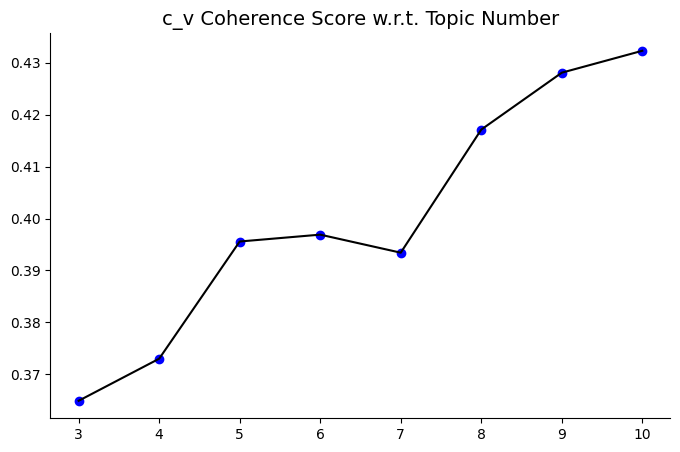

In [ ]:
##https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
id2token_risk_article = corpora.Dictionary(list(risk_article['Phrase_Lemma_Tokens']))
##eliminate rare and frequent tokens
#id2token_risk_article.filter_extremes(no_below=2, no_above=0.8,
#                                       keep_tokens=['smoke','smoking','smoker'])
corpus_risk_article = [id2token_risk_article.doc2bow(tokens)
                        for tokens in list(risk_article['Phrase_Lemma_Tokens'])]

begin_time = time.time()
coherence_scores = []
for nb_topics in tqdm(range(3,11)):
    lda_model = LdaMulticore(corpus=corpus_risk_article,
                            id2word=id2token_risk_article,
                            num_topics=nb_topics,
                            random_state=98,
                            chunksize=100,
                            passes=10,
                            iterations=50,
                            decay=0.5,
                            per_word_topics=True,)
    #cm = CoherenceModel(model=lda_model, corpus=corpus_smoke_article, coherence='u_mass')
    cm = CoherenceModel(model=lda_model,
                        texts=list(risk_article['Phrase_Lemma_Tokens']),
                        dictionary=id2token_risk_article,
                        coherence='c_v',
                        topn=20)
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)

print(f'Topic number selection took {time.time()-begin_time} seconds')

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(3,11),coherence_scores,color='black')
ax.scatter(range(3,11),coherence_scores,marker='o',color='blue')
ax.set_xticks(range(3,11,1))
ax.set_title('c_v Coherence Score w.r.t. Topic Number',fontsize=14)
#ax.set_xlabel('Number of Topics',fontsize=14)
for pos in ['top','right']:
    ax.spines[pos].set_color(None)

In [ ]:
lda_model = LdaMulticore(corpus=corpus_risk_article,
                        id2word=id2token_risk_article,
                        num_topics=6,
                        random_state=98,
                        chunksize=100,
                        passes=10,
                        iterations=50,
                        decay=0.5,
                        per_word_topics=True,)

print('Perplexity: ', lda_model.log_perplexity(corpus_risk_article))

Perplexity:  -8.178395041929358


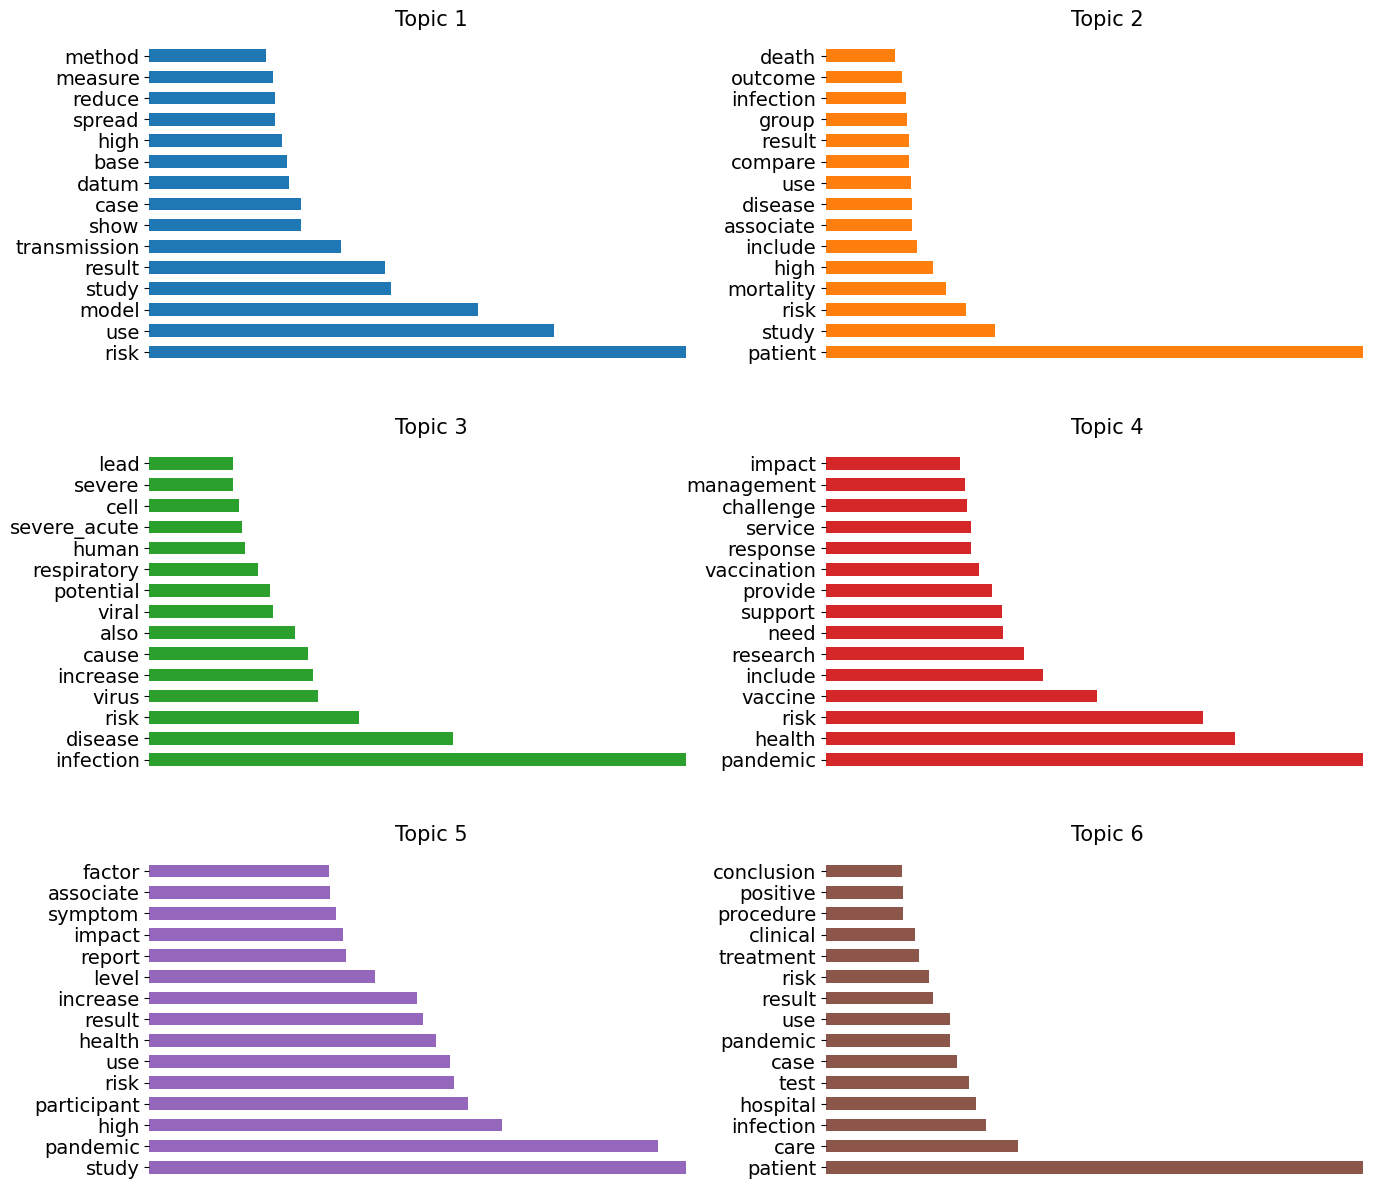

In [ ]:
word_topic_scores = lda_model.show_topics(num_words=15,formatted=False)

fig = plt.figure(figsize=(16,15))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    #word_score_dict = dict(topic[1])
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    #fig,ax = plt.subplots(figsize=(7,5))
    ax = fig.add_subplot(3,2,i+1)
    ax.barh(y=words,width=probs,height=0.6,color=sns.color_palette()[i])
    ax.set_yticklabels(labels=words, fontsize=14)
    ax.set_xticks([])
    ax.set_title(f'Topic {i+1}',fontsize=15)
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

In [ ]:
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpus_risk_article)):
    document_topic = lda_model.get_document_topics(corpus_risk_article[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1

topic_frequency = dict(sorted(topic_frequency.items()))

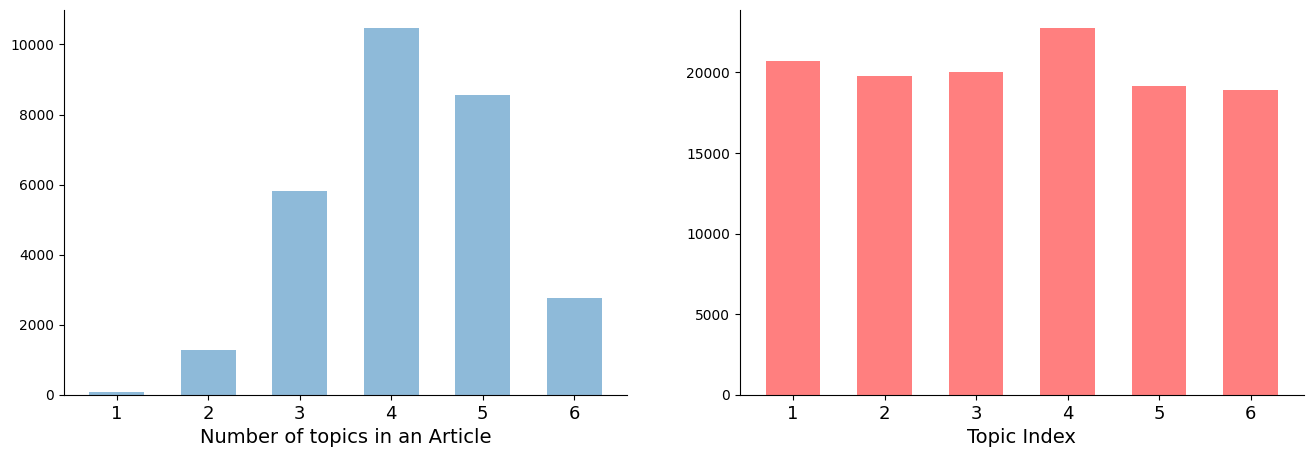

In [ ]:
#num_topic_document_counter = collections.Counter(num_topic_document)
num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='red',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color(None)
    ax.set_xticklabels(['1','2','3','4','5','6'],fontsize=13)

In [ ]:
## Generate document topic matrix
document_topic_matrix = np.zeros((len(corpus_risk_article),6))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix).head()

,0,1,2,3,4,5
0,0.051901,0.066521,0.000000,0.155376,0.233579,0.491356
1,0.121360,0.000000,0.000000,0.354459,0.282739,0.238330
2,0.000000,0.053265,0.639966,0.066038,0.218038,0.020242
3,0.208994,0.341562,0.149418,0.000000,0.000000,0.295436
4,0.642157,0.000000,0.067037,0.249150,0.039519,0.000000


In [ ]:
tSNE = TSNE(n_components=2,init='pca',random_state=98)
embedding_matrix = tSNE.fit_transform(document_topic_matrix)
df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow',
                  3: 'red', 4: 'skyblue', 5:'salmon'}
df_embedding['dominant_topic_idx'] = np.argmax(document_topic_matrix,axis=1)
df_embedding['color'] = df_embedding['dominant_topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Treatment Methods', 1: 'Mental Health and Behavior', 2: 'Severity of Disease',
                  3: 'Transmission of Virus', 4: 'Public and Social Service', 5:'Death'}
df_embedding['label'] = df_embedding['dominant_topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(risk_article['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['dominant_topic_idx'],
         title= df_embedding['article_title'],
         #content =
        ))

lda_plot = figure(title='T-SNE Clustering of LDA Topics',
              width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover',
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source,
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

NameError: ignored